# 1)-Importing key modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# 2)-Loading dataset

In [5]:
df = pd.read_json('newsgroups.json')

In [6]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [7]:
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [8]:
df.columns

Index(['content', 'target', 'target_names'], dtype='object')

# 3)-Data preprocessing

### 3.1)-Prepare Stopwords

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# we can always modify our stopword list
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### 3.2)-emails letters, newline and extra spaces

As our key feature is content so, we will perform all preprocessing step over this one. Let's make it a list first

In [10]:
# Convert to list
data = df.content.values.tolist()

In [11]:
type(data)

list

In [12]:
pprint(data[0])

("From: lerxst@wam.umd.edu (where's my thing)\n"
 'Subject: WHAT car is this!?\n'
 'Nntp-Posting-Host: rac3.wam.umd.edu\n'
 'Organization: University of Maryland, College Park\n'
 'Lines: 15\n'
 '\n'
 ' I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.\n'
 '\n'
 'Thanks,\n'
 '- IL\n'
 '   ---- brought to you by your neighborhood Lerxst ----\n'
 '\n'
 '\n'
 '\n'
 '\n')


In [13]:
# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]

In [14]:
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

In [15]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [16]:
pprint(data[0])

('From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ')


### 3.3)- Tokenize words and Clean-up text
We need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s **simple_preprocess** is great for this.

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [18]:
print(data_words[0])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### 3.4)-Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s 'Phrases' model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are 'min_count' and 'threshold'. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### 3.5)-Remove Stopwords, Make Bigrams and Lemmatize

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    """Also adding postags"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Lets call functions now

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [23]:
type(data_lemmatized)

list

In [24]:
print(data_lemmatized[0])

['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


In [25]:
print(data_lemmatized[:2])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'si', 'clock', 'report', 'keyword', 'si', 'acceleration', 'clock', 'upgrade', 'article', 'shelley', 'qvfo', 'innc', 'organization', 'university', 'washington', 'line', 'nntp_poste', 'host', 'carson_washington', 'fair', 'number', 'brave', 'soul', 'upgrade', 'si', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 

### 3.6)-Create the Dictionary and Corpus needed for Topic Modeling

Two main inputs to the LDA topic model are the **dictionary(id2word)** and the **corpus**.

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
len(corpus)

11314

In [28]:
# View
print(corpus[0])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [29]:
print(id2word[0])
print(id2word[1])

addition
anyone


Or, you can see a human-readable form of the corpus itself.

In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

# 4)- LDA Model
We have everything required to train the LDA model. In addition to the **corpus and dictionary**, you need to provide the **number of topics** as well.

Apart from that, **alpha** and **eta** are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

**chunksize** is the number of documents to be used in each training chunk. **update_every** determines how often the model parameters should be updated and **passes** is the total number of training passes.

In [31]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### 4.1)-View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using **lda_model.print_topics()**.

In [32]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"mhz" + 0.042*"professional" + 0.035*"jeff" + 0.028*"microsoft" + '
  '0.026*"lee" + 0.026*"dos" + 0.024*"pennsylvania" + 0.019*"upenn" + '
  '0.018*"toolkit" + 0.017*"borland"'),
 (1,
  '0.016*"god" + 0.013*"christian" + 0.012*"believe" + 0.011*"may" + '
  '0.010*"claim" + 0.010*"would" + 0.010*"mean" + 0.010*"say" + 0.009*"word" + '
  '0.009*"point"'),
 (2,
  '0.124*"israel" + 0.091*"israeli" + 0.061*"arab" + 0.044*"case_western" + '
  '0.043*"reserve_university" + 0.029*"palestinian" + 0.024*"policy_research" '
  '+ 0.016*"center" + 0.014*"host_hela" + 0.013*"kent"'),
 (3,
  '0.036*"command" + 0.035*"morning" + 0.034*"gay" + 0.031*"marriage" + '
  '0.031*"sex" + 0.030*"homosexual" + 0.027*"husband" + 0.026*"count" + '
  '0.021*"marry" + 0.020*"gospel"'),
 (4,
  '0.134*"key" + 0.049*"encryption" + 0.039*"font" + 0.035*"clipper" + '
  '0.034*"clipper_chip" + 0.027*"security" + 0.025*"algorithm" + '
  '0.024*"secure" + 0.023*"proposal" + 0.022*"nsa"'),
 (5,
  '0.027*"loop

Topic 0 is a represented as **'0.193*"game" + 0.085*"hockey" + 0.044*"league" + 0.037*"chicago" + '
  '0.036*"baseball" + 0.024*"play" + 0.024*"blue" + 0.024*"shot" + '
  '0.022*"hall" + 0.021*"penalty”.**

It means the top 10 keywords that contribute to this topic are: ‘game’, ‘hockey’, ‘league’.. and so on and the weight of ‘ga,e’ on topic 0 is 0.193.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘sports’ or ‘hockey-game’.

Likewise, can you go through the remaining topic keywords and judge what the topic is

### 4.2)- Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.704476734613515

Coherence Score:  0.48147264926535244


### 4.3)-Visualize the topics-keywords

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.381517  0.098510       1        1  31.125778
6     -0.353799  0.097590       2        1  16.886122
14    -0.300405  0.011902       3        1  15.980350
1     -0.335763  0.100181       4        1  13.449508
9     -0.169006 -0.087875       5        1   5.485383
12    -0.086801 -0.441665       6        1   4.515283
8     -0.119968 -0.010541       7        1   3.470651
17    -0.037247 -0.094688       8        1   3.089286
18     0.130937  0.014550       9        1   0.826760
4      0.106664  0.018544      10        1   0.786115
10     0.131061  0.015475      11        1   0.713014
7      0.129350  0.019005      12        1   0.679806
19     0.133950  0.024070      13        1   0.657887
15     0.147740  0.027088      14        1   0.545035
13     0.150994  0.026952      15        1   0.513808
3      0.144250  0.022742      16        1   0.512875
2      0.154843  0.031561      17        1   0.327041
0      0.180136  0.039779      18        1   0.237871
11     0.175686  0.039747      19        1   0.165166
5      0.198893  0.047071      20        1   0.032259, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
4102   Default  61480.000000              ax  61480.000000  30.0000  30.0000
80     Default  24932.000000             not  24932.000000  29.0000  29.0000
21     Default  18770.000000            line  18770.000000  28.0000  28.0000
322    Default  14204.000000           write  14204.000000  27.0000  27.0000
3679   Default   4339.000000             max   4339.000000  26.0000  26.0000
30     Default  16621.000000    organization  16621.000000  25.0000  25.0000
53     Default  11150.000000         article  11150.000000  24.0000  24.0000
210    Default   3570.000000          window   3570.000000  23.0000  23.0000
63     Default  15642.000000              do  15642.000000  22.0000  22.0000
241    Default  12223.000000              be  12223.000000  21.0000  21.0000
48     Default   5379.000000            year   5379.000000  20.0000  20.0000
301    Default  10353.000000             say  10353.000000  19.0000  19.0000
58     Default   3161.000000            card   3161.000000  18.0000  18.0000
1880   Default   2125.000000           space   2125.000000  17.0000  17.0000
260    Default   2026.000000           drive   2026.000000  16.0000  16.0000
668    Default   4467.000000         problem   4467.000000  15.0000  15.0000
116    Default  10288.000000             get  10288.000000  14.0000  14.0000
201    Default   5280.000000          system   5280.000000  13.0000  13.0000
410    Default   7427.000000          people   7427.000000  12.0000  12.0000
2696   Default   2983.000000            game   2983.000000  11.0000  11.0000
336    Default   3447.000000           state   3447.000000  10.0000  10.0000
672    Default   4377.000000           right   4377.000000   9.0000   9.0000
561    Default   2833.000000            team   2833.000000   8.0000   8.0000
747    Default   1673.000000             key   1673.000000   7.0000   7.0000
316    Default   7115.000000             use   7115.000000   6.0000   6.0000
221    Default   8804.000000              go   8804.000000   5.0000   5.0000
106    Default   2432.000000             bit   2432.000000   4.0000   4.0000
1344   Default   2363.000000      government   2363.000000   3.0000   3.0000
149    Default  13930.000000           would  13930.000000   2.0000   2.0000
42     Default   3914.000000           thank   3914.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
70453  Topic20      0.006772          aplace      1.109545   2.9402 -11.2318
70454  Topic20      0.006772  incompressible      1.109545   2.9402 -11.2318
70455  Topic20      0.006772          shoulf      1.109545   2.9402 -11.23

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## to find the optimal number of topics for LDA

In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

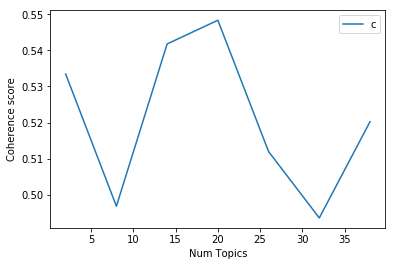

In [63]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [64]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5334
Num Topics = 8  has Coherence Value of 0.4969
Num Topics = 14  has Coherence Value of 0.5418
Num Topics = 20  has Coherence Value of 0.5483
Num Topics = 26  has Coherence Value of 0.512
Num Topics = 32  has Coherence Value of 0.4937
Num Topics = 38  has Coherence Value of 0.5203


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [65]:
# Select the model and print the topics
optimal_model = model_list[3] # 3 is the location i.e 0=topic2,1=topic8,2=topic14,3=topic20
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"team" + 0.019*"game" + 0.011*"year" + 0.011*"player" + 0.011*"win" + '
  '0.010*"line" + 0.010*"play" + 0.009*"not" + 0.008*"season" + 0.007*"get"'),
 (1,
  '0.015*"line" + 0.012*"organization" + 0.011*"window" + 0.010*"not" + '
  '0.008*"do" + 0.008*"get" + 0.008*"file" + 0.008*"use" + 0.007*"write" + '
  '0.007*"problem"'),
 (2,
  '0.014*"write" + 0.013*"not" + 0.012*"article" + 0.012*"line" + '
  '0.011*"organization" + 0.010*"get" + 0.008*"do" + 0.007*"be" + 0.006*"know" '
  '+ 0.005*"would"'),
 (3,
  '0.018*"armenian" + 0.010*"israel" + 0.009*"israeli" + 0.007*"jew" + '
  '0.007*"arab" + 0.007*"government" + 0.007*"people" + 0.006*"turkish" + '
  '0.006*"turk" + 0.005*"war"'),
 (4,
  '0.011*"homosexual" + 0.009*"israel" + 0.008*"write" + 0.007*"man" + '
  '0.007*"article" + 0.007*"gay" + 0.007*"zoroastrian" + 0.006*"line" + '
  '0.006*"clayton_cramer" + 0.005*"organization"'),
 (5,
  '0.021*"space" + 0.007*"april" + 0.006*"national" + 0.006*"satellite" + '
  '0.006*

### Finding the dominant topic in each sentence

In [66]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.3476,"not, say, do, be, go, write, would, people, know, think",From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organiza...
1,1,1.0,0.5667,"line, organization, window, not, do, get, file, use, write, problem",From: (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for SI clock reports Key...
2,2,7.0,0.4537,"not, line, organization, write, do, article, be, get, time, host",From: (Irwin Arnstein) Subject: Re: Recommendation on Duc Summary: Whats it worth? Distribution:...
3,3,1.0,0.7415,"line, organization, window, not, do, get, file, use, write, problem",From: (Tsung-Kun Chen) Subject: ** Software forsale (lots) ** Nntp-Posting-Host: magnusug.magnus...
4,4,1.0,0.9762,"line, organization, window, not, do, get, file, use, write, problem","From: (Don A.B. Lindbergh) Subject: Diamond SS24X, Win 3.1, Mouse cursor Organization: National ..."
5,5,7.0,0.6188,"not, line, organization, write, do, article, be, get, time, host",From: (Robert Loper) Subject: Re: SHO and SC Nntp-Posting-Host: sun278.dseg.ti.com Organization:...
6,6,15.0,0.6169,"line, not, organization, key, would, get, use, do, know, good",From: (Kim Richard Man) Subject: SyQuest 44M cartrifge FORSALE Article-I.D.: magnus.1993Apr17.17...
7,7,1.0,0.5580,"line, organization, window, not, do, get, file, use, write, problem",From: (Kirtley Wilson) Subject: Mirosoft Office Package Article-I.D.: news.1993Apr6.183345.28238...
8,8,6.0,0.5727,"not, say, do, be, go, write, would, people, know, think",Subject: Re: Dont more innocents die without the death penalty? From: (Robert Beauchaine) Organi...
9,9,13.0,0.7104,"not, would, write, say, people, think, do, line, organization, may",From: (Jon Livesey) Subject: Re: Genocide is Caused by Atheism Organization: sgi Lines: 38 Distr...


### Find the most representative document for each topic

In [67]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9955,"team, game, year, player, win, line, play, not, season, get","From: (Rocket) Subject: NHL Playoff leaders as of April 19, 1993 Organization: University of New..."
1,1.0,0.9949,"line, organization, window, not, do, get, file, use, write, problem","From: (Jan van Loenen) Subject: Re: Diamond SS24X, Win 3.1, Mouse cursor Lines: 47 (Don A.B. Lin..."
2,2.0,0.9924,"write, not, article, line, organization, get, do, be, know, would","From: (Gordon Banks) Subject: Re: Update (Help!) [was ""What is This [Is it Lymes?]""] Reply-To: (..."
3,3.0,0.9947,"armenian, israel, israeli, jew, arab, government, people, turkish, turk, war",From: (Ahmed Abu-Abed) Subject: Re: Final Solution in Palestine ? Originator: Nntp-Posting-Host:...
4,4.0,0.9893,"homosexual, israel, write, man, article, gay, zoroastrian, line, clayton_cramer, organization",From: (Clayton Cramer) Subject: New Study Out On Gay Percentage Organization: Optilink Corporati...


### Topic distribution across documents

In [68]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"not, say, do, be, go, write, would, people, know, think",755.0,0.0667
1,1.0,"line, organization, window, not, do, get, file, use, write, problem",2860.0,0.2528
2,7.0,"not, line, organization, write, do, article, be, get, time, host",430.0,0.0380
3,1.0,"line, organization, window, not, do, get, file, use, write, problem",321.0,0.0284
4,1.0,"line, organization, window, not, do, get, file, use, write, problem",40.0,0.0035
5,7.0,"not, line, organization, write, do, article, be, get, time, host",193.0,0.0171
6,15.0,"line, not, organization, key, would, get, use, do, know, good",1583.0,0.1399
7,1.0,"line, organization, window, not, do, get, file, use, write, problem",944.0,0.0834
8,6.0,"not, say, do, be, go, write, would, people, know, think",12.0,0.0011
9,13.0,"not, would, write, say, people, think, do, line, organization, may",59.0,0.0052


END here if all go fine

# 5) Dominant topic and its percentage contribution in each document

In [54]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.4410,"not, line, organization, do, write, be, articl...","[where, s, thing, car, nntp_poste, host, umd, ..."
1,1,14.0,0.4987,"system, use, thank, line, information, new, al...","[clock, poll, final, call, summary, final, cal..."
2,2,16.0,0.4403,"not, line, organization, do, write, be, articl...","[irwin, arnstein, recommendation, duc, summary..."
3,3,14.0,0.3653,"system, use, thank, line, information, new, al...","[tsung, kun, chen, software, forsale, lot, nnt..."
4,4,16.0,0.3843,"not, line, organization, do, write, be, articl...","[lindbergh, diamond_ss, win, mouse_cursor, org..."
5,5,16.0,0.5582,"not, line, organization, do, write, be, articl...","[robert, loper, sc, nntp_posting, host, sun, d..."
6,6,16.0,0.3101,"not, line, organization, do, write, be, articl...","[kim, richard, man, syqu, cartrifge, forsale, ..."
7,7,14.0,0.3545,"system, use, thank, line, information, new, al...","[kirtley, wilson, mirosoft, office, package, a..."
8,8,16.0,0.2981,"not, line, organization, do, write, be, articl...","[do, not, innocents_die, death_penalty, robert..."
9,9,1.0,0.5462,"god, christian, believe, may, claim, would, me...","[jon_livesey, genocide, cause, atheism, organi..."


### 5.1)-The most representative sentence for each topic

In [55]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.7208,"god, christian, believe, may, claim, would, mean, say, word, point","[mail, server, cause, line, stephen_mcintyre, write, write, stuff_delet, fortunately, convenienc..."
1,6.0,0.6382,"say, people, go, come, time, day, take, see, not, tell","[david_davidian, account, anti, armenian, human, right, violation, azerbaijan, summary, part, or..."
2,8.0,0.4259,"government, gun, law, state, right, public, american, police, country, criminal","[larry_cipriani, gun, talk, state, legislative, update, organization, ideology_buster, inc, keyw..."
3,9.0,0.7853,"year, game, team, play, win, player, hockey, season, first, hit","[nhl, summary_parse, result, game, play, sit, april, cook_charlie, organization, university, lin..."
4,12.0,0.9978,"ax, max, usenet, byte, cd, quadra, counter, centris, alaska, assistance","[cliff, reply, cliff, organization, university, south_dakota, line, part, max, ax, ax, ax, ax, a..."
5,13.0,0.2547,"circuit, league, baseball, directory, front, bob, uk, pub, wear, duke","[todd, karlin, new, uniform, organization, university, virginia, line, usually, team, change, lo..."
6,14.0,0.6757,"system, use, thank, line, information, new, also, mail, file, include","[mark, gregory, avi, file, format, summary, avi, file, format, keyword, avi, file, format, organ..."
7,16.0,0.7572,"not, line, organization, do, write, be, article, would, get, know","[bill, big, big, st, bike, organization, cafe, edge, universe, line, woodward, write, weight, si..."
8,17.0,0.5362,"window, card, chip, driver, color, graphic, bit, mode, problem, board","[grubb, ide_vs, scsi, organization, state, university, line, distribution_world, nntp_posting, h..."
9,18.0,0.5811,"air, hall, purchase, discipline, michigan, van, coverage, archive, panel, complain","[cliff, reply, cliff, organization, university, south_dakota, line, part, nahfnajz, ahf, ajz, kh..."


### 5.3)Frequency Distribution of Word Counts in Documents

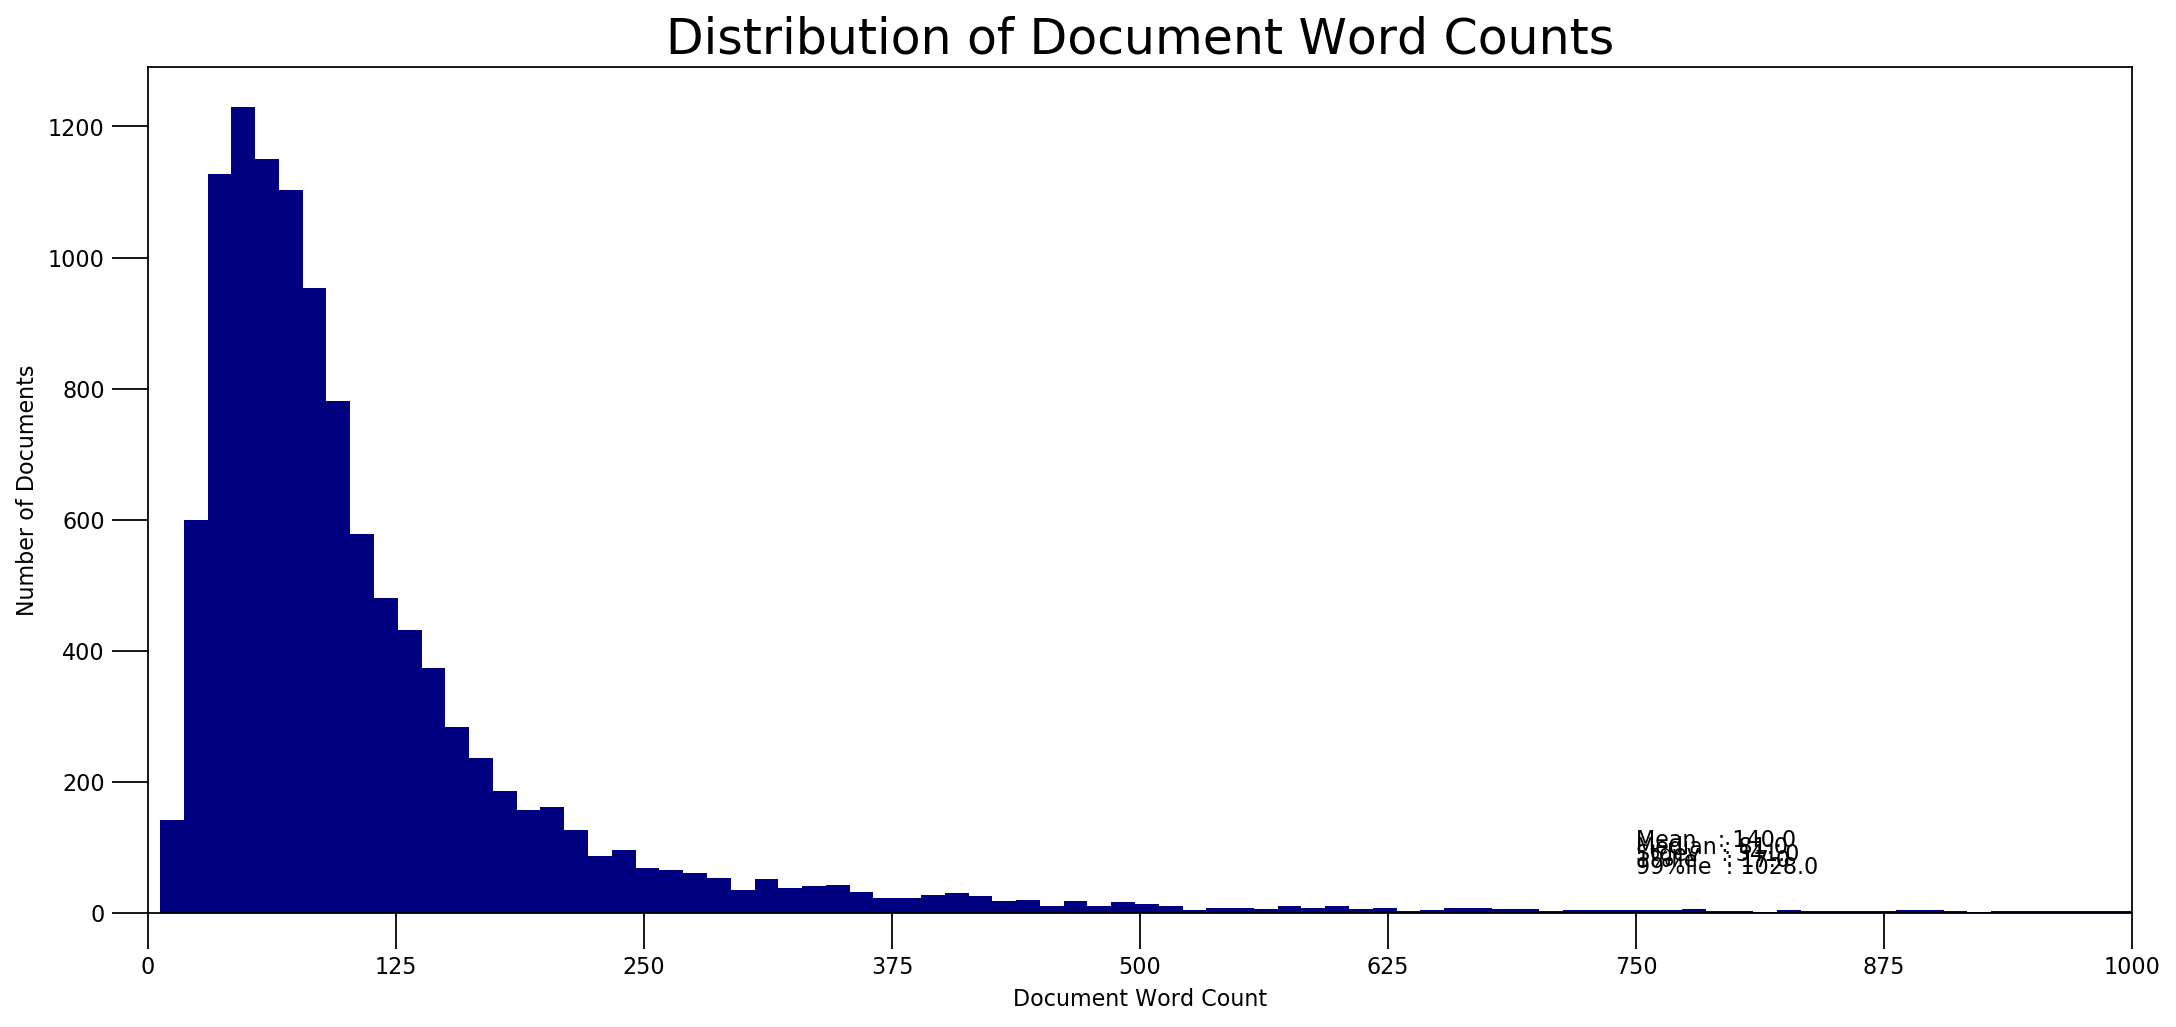

In [56]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:59: DeprecationWarning: invalid escape sequence \l
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:102: DeprecationWarning: invalid escape sequence \l
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:301: DeprecationWarning: invalid escape sequence \l
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:326: DeprecationWarning: invalid escape sequence \i
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:499: DeprecationWarning: invalid escape sequence \s
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:309: DeprecationWarning: invalid escape sequence \s
  """
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:635: DeprecationWarning: invalid escape sequ

ZeroDivisionError: 0.0 cannot be raised to a negative power

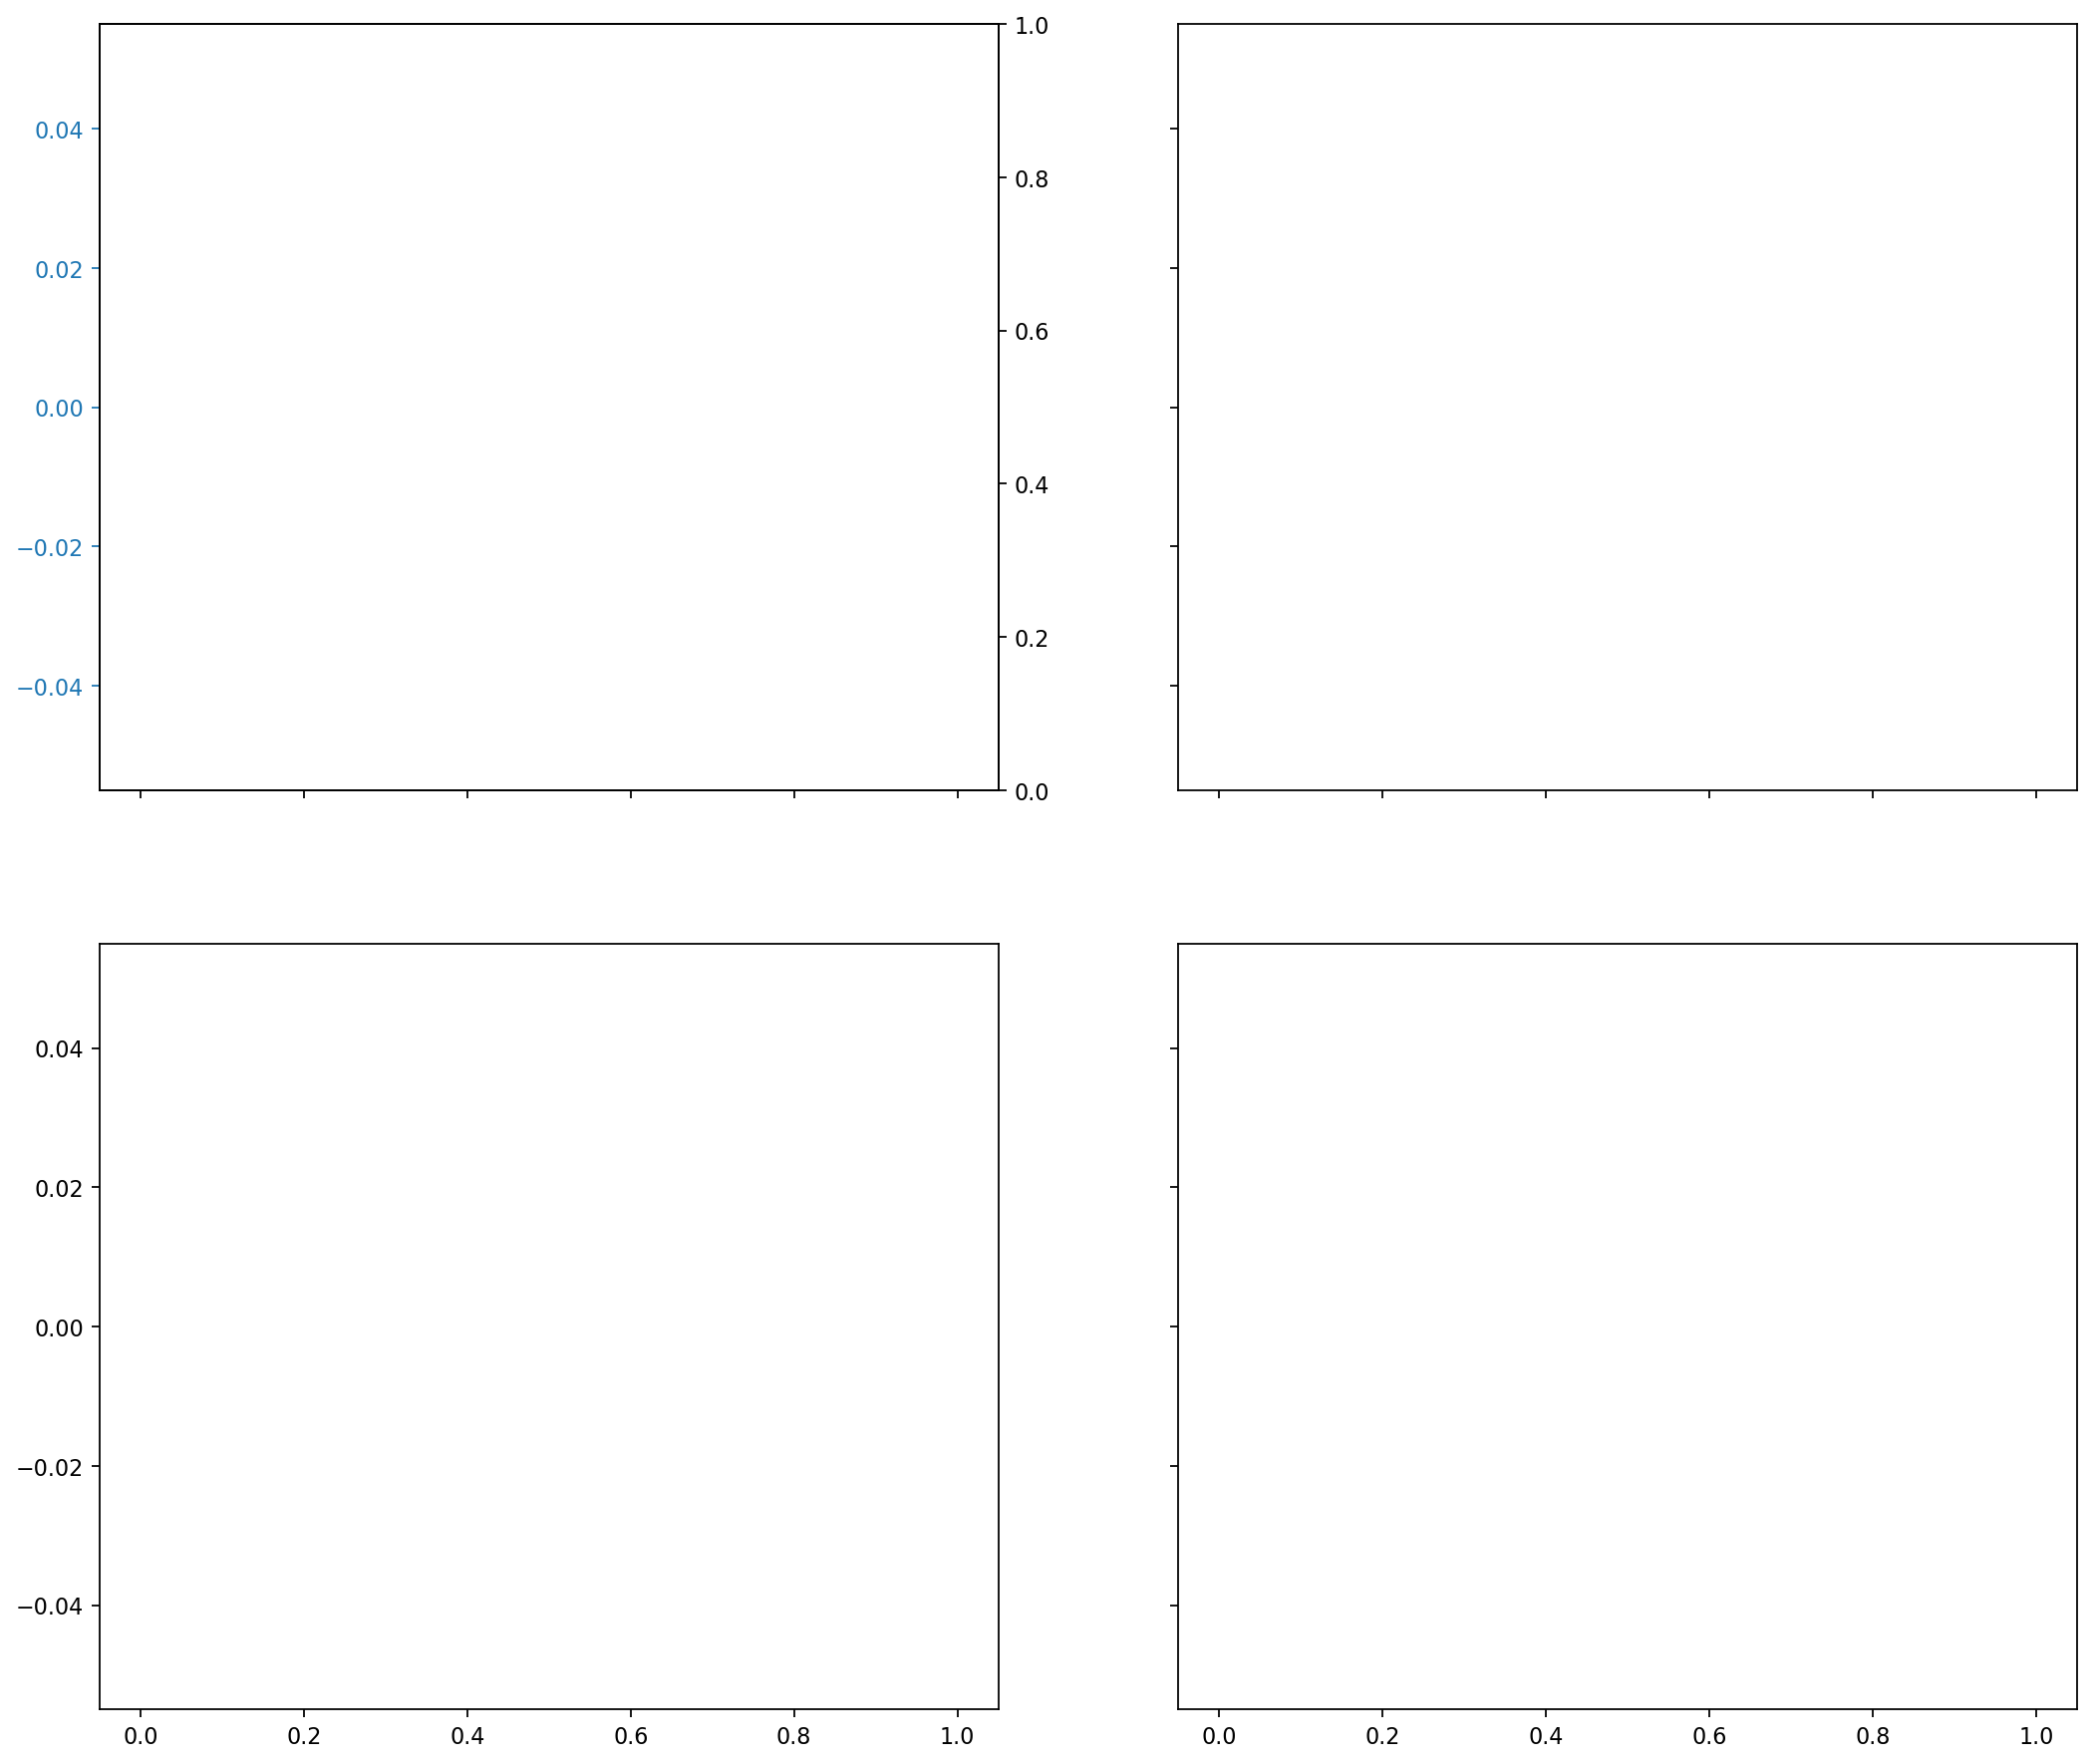

In [57]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### 4.4)-Building LDA Mallet Model

In [36]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\users\\biney\\mallet_unzipped\\mallet-2.0.8'

mallet_path = 'C:\\users\\biney\\mallet_unzipped\\mallet-2.0.8\\bin\\mallet'
ldamallet = LdaMallet(mallet_path,corpus=corpus, num_topics=20, id2word=id2word,iterations=30)

CalledProcessError: Command 'C:\users\biney\mallet_unzipped\mallet-2.0.8\bin\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\531530_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\531530_corpus.mallet' returned non-zero exit status 1.

In [37]:
# download, unzip and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'C:\\Users\\69785hsh\\Downloads\\Data Science\\Learning Projects\\Topic_Modeling\\20_news\\mallet-2.0.8'

mallet_path = 'C:\\Users\\69785hsh\\Downloads\\Data Science\\Learning Projects\\Topic_Modeling\\20_news\\mallet-2.0.8\\\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'C:\Users\69785hsh\Downloads\Data Science\Learning Projects\Topic_Modeling\20_news\mallet-2.0.8\\bin\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\fe1cad_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\fe1cad_corpus.mallet' returned non-zero exit status 1.

In [38]:
mallet_path = 'mallet-2.0.8\bin\mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

<>:1: DeprecationWarning: invalid escape sequence \m
<>:1: DeprecationWarning: invalid escape sequence \m
<>:1: DeprecationWarning: invalid escape sequence \m
<ipython-input-38-c0c8d39d7710>:1: DeprecationWarning: invalid escape sequence \m
  mallet_path = 'mallet-2.0.8\bin\mallet'


CalledProcessError: Command 'mallet-2.0.8in\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\a5895b_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\a5895b_corpus.mallet' returned non-zero exit status 1.

In [39]:
mallet_path = r'mallet-2.0.8\\bin\\mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'mallet-2.0.8\\bin\\mallet.bat import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\2b0ee6_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\2b0ee6_corpus.mallet' returned non-zero exit status 1.

In [40]:
import pathlib
os.environ['MALLET_HOME'] = r'C:\mallet-2.0.8'
mallet_path = Path("C:", "mallet-2.0.8", "bin","mallet.bat")
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

NameError: name 'Path' is not defined

In [41]:
os.environ['MALLET_HOME'] = 'C:\mallet-2.0.8'
mallet_path = 'C:\mallet-2.0.8\bin\mallet'
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word

SyntaxError: unexpected EOF while parsing (<ipython-input-41-b3954b289f5e>, line 3)

In [42]:
import os
os.environ.update({r'MALLET_HOME':r'C:/mallet-2.0.8/'})

mallet_path = r'C:\mallet-2.0.8\bin\mallet' # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

CalledProcessError: Command 'C:\mallet-2.0.8\bin\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\4adbb3_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\4adbb3_corpus.mallet' returned non-zero exit status 1.

In [43]:
import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path

ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'C:/new_mallet/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\24a2fd_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\24a2fd_corpus.mallet' returned non-zero exit status 1.

In [ ]:
mallet_path = 'mallet-2.0.8//bin//mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [51]:
mallet_path = r'mallet-2.0.8//bin//mallet' 

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'mallet-2.0.8//bin//mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\69785hsh\AppData\Local\Temp\1\7a9f82_corpus.txt --output C:\Users\69785hsh\AppData\Local\Temp\1\7a9f82_corpus.mallet' returned non-zero exit status 1.